In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,datasets
import cv2
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import random

In [3]:
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS = 3

TRAIN_PATH = 'unetpp_data/stage1_train/'
TEST_PATH = 'unetpp_data/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

#Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

#Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_test[n] = img

c:\ProgramData\anaconda3\envs\su7\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
  0%|          | 0/670 [00:00<?, ?it/s]c:\ProgramData\anaconda3\envs\su7\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
100%|██████████| 65/65 [00:01<00:00, 33.71it/s]

uint8


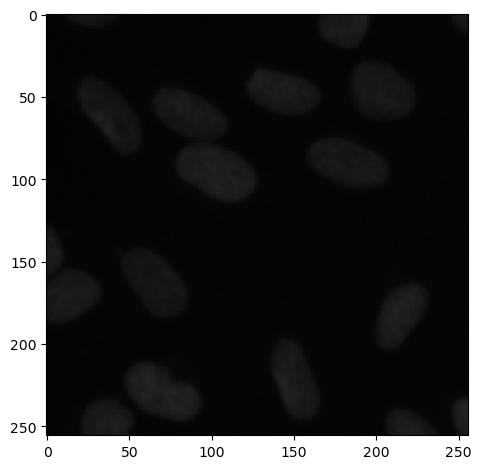

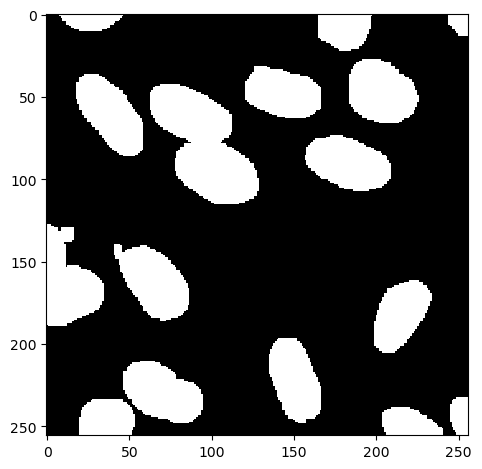

In [9]:
ix = random.randint(0, len(train_ids))
print(X_train[ix].dtype)
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix])
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle = False)

print(len(x_train), len(x_valid))

536 134


In [6]:
class Nuclie_dataset(Dataset):
    def __init__(self, img_data, label_data = None, train = False, transforms=None):
        self.train = train
        self.transforms = transforms
        self.img_data = img_data
        self.label_data = label_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        if self.transforms is not None:
            img = self.transforms(self.img_data[index])
            label = self.transforms(self.label_data[index])
        elif self.label_data is not None: 
            img = self.img_data[index]
            label = self.label_data[index]
        else:
            img = self.img_data[index]
        if self.train:
            return img, label
        else:
            return img

In [7]:
test1 = Nuclie_dataset(img_data=X_test, train = False)
test11 = DataLoader(test1, batch_size=5, shuffle=False)
test_i= next(iter(test11))
test_i.shape
#print(test1.__getitem__(0)[0].shape)
#imshow(test1.__getitem__(0)[0])

torch.Size([5, 256, 256, 3])

In [8]:
def weights_init_kaimimg(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net):
    net.apply(weights_init_kaimimg)
  

In [9]:
class Unet_block(nn.Module):
    def __init__(self, in_c, mid_c, out_c):
        super(Unet_block, self).__init__()
        self.conv1 = nn.Conv2d(in_c, mid_c, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(mid_c)
        self.conv2 = nn.Conv2d(mid_c, out_c, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

In [10]:
class UNetpp(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False):
        super().__init__()

        num_filter = [32, 64, 128, 256, 512]
        self.deep_supervision = deep_supervision
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # DownSampling
        self.conv0_0 = Unet_block(input_channels, num_filter[0], num_filter[0])
        self.conv1_0 = Unet_block(num_filter[0], num_filter[1], num_filter[1])
        self.conv2_0 = Unet_block(num_filter[1], num_filter[2], num_filter[2])
        self.conv3_0 = Unet_block(num_filter[2], num_filter[3], num_filter[3])
        self.conv4_0 = Unet_block(num_filter[3], num_filter[4], num_filter[4])

        # Upsampling & Dense skip
        # N to 1 skip
        self.conv0_1 = Unet_block(num_filter[0] + num_filter[1], num_filter[0], num_filter[0])
        self.conv1_1 = Unet_block(num_filter[1] + num_filter[2], num_filter[1], num_filter[1])
        self.conv2_1 = Unet_block(num_filter[2] + num_filter[3], num_filter[2], num_filter[2])
        self.conv3_1 = Unet_block(num_filter[3] + num_filter[4], num_filter[3], num_filter[3])
       
        # N to 2 skip
        self.conv0_2 = Unet_block(num_filter[0]*2 + num_filter[1], num_filter[0], num_filter[0])
        self.conv1_2 = Unet_block(num_filter[1]*2 + num_filter[2], num_filter[1], num_filter[1])
        self.conv2_2 = Unet_block(num_filter[2]*2 + num_filter[3], num_filter[2], num_filter[2])

        # N to 3 skip
        self.conv0_3 = Unet_block(num_filter[0]*3 + num_filter[1], num_filter[0], num_filter[0])
        self.conv1_3 = Unet_block(num_filter[1]*3 + num_filter[2], num_filter[1], num_filter[1])

        # N to 4 skip
        self.conv0_4 = Unet_block(num_filter[0]*4 + num_filter[1], num_filter[0], num_filter[0])

        if self.deep_supervision:
            self.output1 = nn.Conv2d(num_filter[0], num_classes, kernel_size=1)
            self.output2 = nn.Conv2d(num_filter[0], num_classes, kernel_size=1)
            self.output3 = nn.Conv2d(num_filter[0], num_classes, kernel_size=1)
            self.output4 = nn.Conv2d(num_filter[0], num_classes, kernel_size=1)

        else:
            self.output = nn.Conv2d(num_filter[0], num_classes, kernel_size=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m)
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m)

    def forward(self, x):                    # (Batch, 3, 256, 256)

        x0_0 = self.conv0_0(x)               
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], dim=1))
        
        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], dim=1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], dim=1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], dim=1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], dim=1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], dim=1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], dim=1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], dim=1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], dim=1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], dim=1))

        if self.deep_supervision:
            output1 = self.output1(x0_1)
            output2 = self.output2(x0_2)
            output3 = self.output3(x0_3)
            output4 = self.output4(x0_4)
            output = (output1 + output2 + output3 + output4) / 4
        else:
            output = self.output(x0_4)

        return output

In [11]:
class UNetwithpadding(nn.Module):
    def __init__(self):
        super(UNetwithpadding, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding = 1):
            layers = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU()
            )
            return layers
        
        #Contracting path
        self.conv1_1 = CBR2d(3, 64)
        self.conv1_2 = CBR2d(64, 64)

        self.maxpool1 = nn.MaxPool2d(2,2)

        self.conv2_1 = CBR2d(64, 128)
        self.conv2_2 = CBR2d(128, 128)

        self.maxpool2 = nn.MaxPool2d(2,2)

        self.conv3_1 = CBR2d(128, 256)
        self.conv3_2 = CBR2d(256, 256)

        self.maxpool3 = nn.MaxPool2d(2,2)

        self.conv4_1 = CBR2d(256, 512)
        self.conv4_2 = CBR2d(512, 512)

        self.maxpool4 = nn.MaxPool2d(2,2)

        self.conv5_1 = CBR2d(512, 1024)
        self.conv5_2 = CBR2d(1024,1024)

        #Expansive path
        self.upcon5 = nn.ConvTranspose2d(1024, 512, 2, 2)

        self.dec4_1 = CBR2d(512 * 2, 512)
        self.dec4_2 = CBR2d(512, 256)
        self.upcon4 = nn.ConvTranspose2d(256, 256, 2, 2)

        self.dec3_1 = CBR2d(256 * 2, 256)
        self.dec3_2 = CBR2d(256, 128)
        self.upcon3 = nn.ConvTranspose2d(128, 128, 2, 2)

        self.dec2_1 = CBR2d(128 * 2, 128)
        self.dec2_2 = CBR2d(128, 64)
        self.upcon2 = nn.ConvTranspose2d(64, 64, 2, 2)

        self.dec1_1 = CBR2d(64 * 2, 64)
        self.dec1_2 = CBR2d(64, 64)

        self.fc = nn.Conv2d(64, 1, 1, 1)

    def forward(self, x):
        conv1_1 = self.conv1_1(x)
        conv1_2 = self.conv1_2(conv1_1)
        pool1 = self.maxpool1(conv1_2)

        conv2_1 = self.conv2_1(pool1)
        conv2_2 = self.conv2_2(conv2_1)
        pool2 = self.maxpool2(conv2_2)
    
        conv3_1 = self.conv3_1(pool2)
        conv3_2 = self.conv3_2(conv3_1)
        pool3 = self.maxpool3(conv3_2)

        conv4_1 = self.conv4_1(pool3)
        conv4_2 = self.conv4_2(conv4_1)
        pool4 = self.maxpool2(conv4_2)

        conv5_1 = self.conv5_1(pool4)
        conv5_2 = self.conv5_2(conv5_1)

        #dec5_1 = self.dec5_1(conv5_2)

        upcon5 = self.upcon5(conv5_2)

        crop_conv4_2 = conv4_2[:, :, 4:60, 4:60]
        cat4 = torch.cat((upcon5, conv4_2), dim=1)
        dec4_1 = self.dec4_1(cat4)
        dec4_2 = self.dec4_2(dec4_1)

        upcon4 = self.upcon4(dec4_2)

        crop_conv3_2 = conv3_2[:, :, 16:120, 16:120]
        cat3 = torch.cat((upcon4, conv3_2), dim=1)
        dec3_1 = self.dec3_1(cat3)
        dec3_2 = self.dec3_2(dec3_1)

        upcon3 = self.upcon3(dec3_2)

        crop_conv2_2 = conv2_2[:, :, 40:240, 40:240]
        cat2 = torch.cat((upcon3, conv2_2), dim=1)
        dec2_1 = self.dec2_1(cat2)
        dec2_2 = self.dec2_2(dec2_1)

        upcon2 = self.upcon2(dec2_2)

        crop_conv1_2 = conv1_2[:, :, 88:480, 88:480]
        #print('upcon2: ', upcon2.shape)
        #print('crop12:', crop_conv1_2.shape)
        cat1 = torch.cat((upcon2, conv1_2), dim=1)
        dec1_1 = self.dec1_1(cat1)
        dec1_2 = self.dec1_2(dec1_1)

        model = self.fc(dec1_2)

        return model

In [10]:
m = UNetpp(1, 3, True)

input = torch.randn((3,3,256,256))
output = m(input)
print(output.shape)

torch.Size([3, 1, 256, 256])


In [13]:
trainset = Nuclie_dataset(x_train, y_train, True)
trainloader = DataLoader(trainset, batch_size = 8, shuffle = True, num_workers=0)

In [86]:
train_i, train_l = next(iter(trainloader))
train_i.shape

torch.Size([8, 256, 256, 3])

In [14]:
validset = Nuclie_dataset(x_valid, y_valid, True)
valid_loader = DataLoader(trainset, batch_size = 67, shuffle = True, num_workers=0)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당
device

device(type='cuda')

In [15]:
testset = Nuclie_dataset(img_data = X_test, train = False)
test_loader = DataLoader(testset, batch_size=5, shuffle=True)

In [91]:
test_i = next((iter(test_loader)))
test_i.shape
#plt.imshow(test_i[2])

torch.Size([5, 256, 256, 3])

In [20]:
import torch.nn.functional as F
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

In [21]:
model = UNetpp(1,3,True).to(device)

epochs = 10

criterion = BCEDiceLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

  0%|          | 0/67 [00:00<?, ?it/s]c:\ProgramData\anaconda3\envs\su7\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
c:\ProgramData\anaconda3\envs\su7\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == "":
100%|██████████| 67/67 [16:52<00:00, 15.11s/it]
c:\ProgramData\anaconda3\envs\su7\lib\site-packages\ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Program

[1] Train loss: 0.3080205917
[1] Valid loss: 0.0331340171


100%|██████████| 67/67 [18:32<00:00, 16.61s/it]


[2] Train loss: 0.3020932172
[2] Valid loss: 0.0351869576


100%|██████████| 67/67 [16:53<00:00, 15.13s/it]


[3] Train loss: 0.3029843504
[3] Valid loss: 0.0390225947


100%|██████████| 67/67 [17:29<00:00, 15.67s/it]


[4] Train loss: 0.3062529350
[4] Valid loss: 0.0358387306


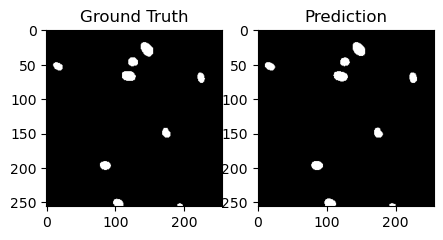

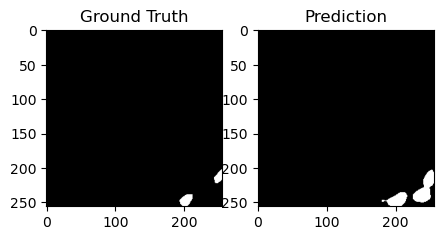

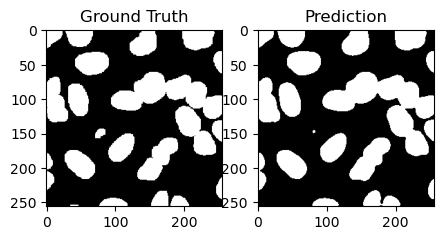

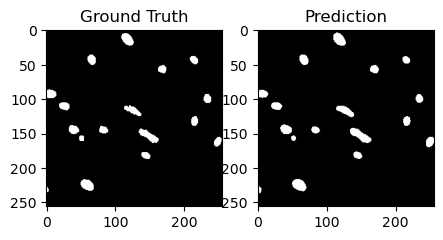

In [42]:
model.to(device)
best_loss = 1
loss_list=[]

for epoch in range(1, 5):
    model.train()
    running_loss = 0.0
    valid_loss = 0.0

    for img, label in tqdm(trainloader, total = len(trainloader)):
        inputs = torch.tensor(img, device=device, dtype=torch.float32)
        labels = torch.tensor(label, device=device, dtype=torch.float32)
        inputs = inputs.permute(0, 3, 1, 2)
        labels = labels.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        pred = model(inputs)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        running_loss += loss.item()

    with torch.no_grad():
        model.eval()
        loss_arr = []
        example_batch = next(iter(valid_loader))
        #img_example, label_example = example_batch[0].to(device), example_batch[1].to(device)
        img_example = torch.tensor(example_batch[0], device=device, dtype=torch.float32)
        label_example = torch.tensor(example_batch[1], device=device, dtype = torch.float32)
        img_example = img_example.permute(0,3,1,2)
        label_example = label_example.permute(0,3,1,2)
        output_example = model(img_example)

        #loss 계산
        loss = criterion(output_example, label_example)
        valid_loss += loss.item()

        output_example_sigmoid = torch.sigmoid(output_example)
        output_example_sigmoid = (output_example_sigmoid > 0.5).float()

        # 시각화를 위해 예측값과 정답값을 numpy 배열로 변환
        output_np = output_example_sigmoid.cpu().detach().numpy()
        y_np = label_example.cpu().detach().numpy()

        # 첫 번째 배치의 예측값과 정답값 시각화
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.squeeze(y_np[0, :, :]), 'gray')
        plt.title('Ground Truth')

        plt.subplot(1, 2, 2)
        plt.imshow(np.squeeze(output_np[0, :, :]), 'gray')
        plt.title('Prediction')
    print('[%d] Train loss: %.10f' %(epoch, running_loss / len(trainloader)))
    print('[%d] Valid loss: %.10f' %(epoch, valid_loss / len(valid_loader)))

    if valid_loss / len(trainloader) < best_loss:
         best_loss = valid_loss / len(trainloader)
         torch.save(model, 'checkpoints/unet++_bcedice_nuc_adamw_model_{}.pt'.format(epoch))

Text(0.5, 1.0, 'unet++_bce_Nuclie')

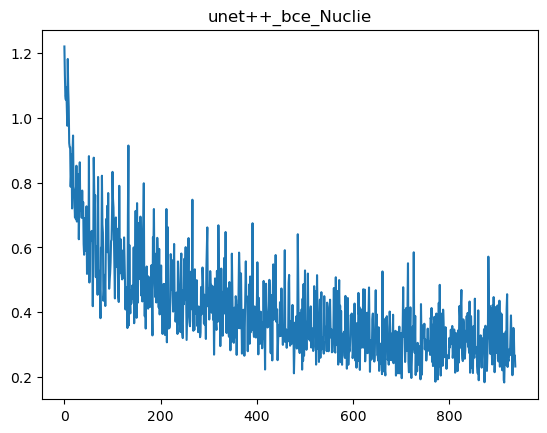

In [43]:
plt.plot(loss_list)
bcedicel = loss_list
plt.title("unet++_bce_Nuclie")

c:\ProgramData\anaconda3\envs\su7\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


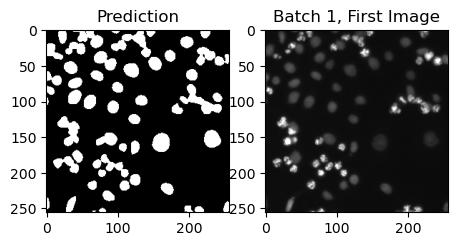

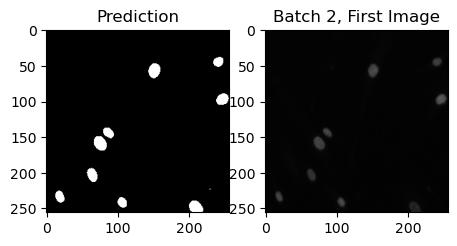

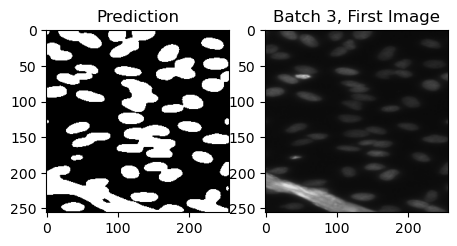

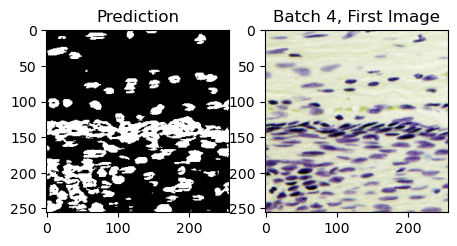

In [42]:
test_loss = []
model = torch.load('checkpoints/unet++_bcedice_nuc_adamw_model_4.pt')

for i in range(4):
        model.eval()
        with torch.no_grad():
                example_batch = next(iter(test_loader))
                img_example = torch.tensor(example_batch, device=device, dtype=torch.float32)
                img_example2 = img_example.permute(0,3,1,2)

                output_example = model(img_example2)

                output_example_sigmoid = torch.sigmoid(output_example)
                output_example_sigmoid = (output_example_sigmoid > 0.5).float()

        # 시각화를 위해 예측값과 정답값을 numpy 배열로 변환
                output_np = output_example_sigmoid.cpu().detach().numpy()
                input_np = img_example2.cpu().detach().numpy()

        # 첫 번째 배치의 예측값과 정답값 시각화
                plt.figure(figsize=(8, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(np.squeeze(output_np[0, :, :]), 'gray')
                plt.title('Prediction')

                plt.subplot(1, 3, 2)
                plt.imshow(example_batch[0])
                plt.title(f'Batch {i + 1}, First Image')

                plt.show()
